In [1]:


import os
import glob
import random
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import scipy.io as scp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import skimage.io as skio
from torch.utils.data import Dataset, DataLoader 
     


In [2]:
class CNN(nn.Module):
    def __init__(self, num_channels=3, num_out_ch=[32, 64, 128], img_w=100, img_h=100, num_classes=102):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, num_out_ch[0], kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.bn1 = nn.BatchNorm2d(num_out_ch[0])
        self.conv2 = nn.Conv2d(num_out_ch[0], num_out_ch[1], kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.bn2 = nn.BatchNorm2d(num_out_ch[1])
        self.conv3 = nn.Conv2d(num_out_ch[1], num_out_ch[2], kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.bn3 = nn.BatchNorm2d(num_out_ch[2])
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.fc = nn.Linear(int(img_w/8)*int(img_h/8)*num_out_ch[2], num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.fc(x.reshape(x.shape[0], -1))
        return x
model = CNN()
x = torch.randn(1, 3, 100, 100)
print(model(x).shape)
y = model(x)
print(y.shape)

torch.Size([1, 102])
torch.Size([1, 102])


In [3]:
# PARAMS
NUM_CHANNELS = [8, 16, 32]
IMG_W = 200
IMG_H = 200
NUM_CLASSES = 102
BATCH_SIZE = 32
NUM_EPOCHS = 6
LEARNING_RATE = 0.001

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("RUNNING ON: ", device)

# model
model = CNN(num_channels=3, num_out_ch=NUM_CHANNELS, img_w=IMG_W, img_h=IMG_H, num_classes=NUM_CLASSES).to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=LEARNING_RATE)

RUNNING ON:  cuda


,image_path,image_label
0,./data/flowers-102/jpg\image_00001.jpg,76
1,./data/flowers-102/jpg\image_00002.jpg,76
2,./data/flowers-102/jpg\image_00003.jpg,76
3,./data/flowers-102/jpg\image_00004.jpg,76
4,./data/flowers-102/jpg\image_00005.jpg,76
...,...,...
8184,./data/flowers-102/jpg\image_08185.jpg,61
8185,./data/flowers-102/jpg\image_08186.jpg,61
8186,./data/flowers-102/jpg\image_08187.jpg,61
8187,./data/flowers-102/jpg\image_08188.jpg,61


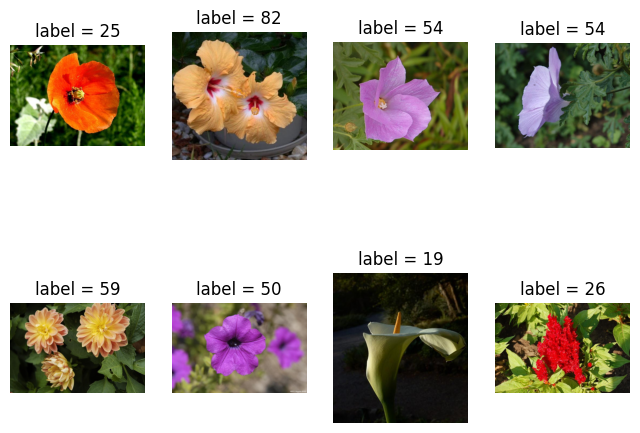

In [4]:
data_path = "./data/flowers-102/jpg"
labels_path = "./data/flowers-102/imagelabels.mat"
label_arr = scp.loadmat(labels_path)['labels']
label_arr -= 1

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8, 6))
image_num = random.sample(range(1, 8189), 8)
for i in range(2):
    for j in range(4):
        image = skio.imread(os.path.join(data_path, f"image_{image_num[i * 4 + j]:05}.jpg"))
        ax[i, j].imshow(image)
        ax[i, j].set_title(f"label = {label_arr[0, image_num[i * 4 + j] - 1]}")
        ax[i, j].axis('off')
labels_list = list(set(label_arr[:, 0]))
image_paths = sorted(glob.glob(os.path.join(data_path, "*.jpg")))
metadata = pd.DataFrame({
    "image_path": image_paths,
    "image_label": label_arr[0, :].tolist()
})
metadata

In [5]:
class FlowerDataset(Dataset):
    def __init__(self, metadata, transform=None) -> None:
        self.metadata = metadata
        self.transform = transform
    
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        image_path = self.metadata.iloc[idx, 0]
        image = skio.imread(image_path)
        label = self.metadata.iloc[idx, 1]
        label = torch.tensor(label)  # Convert label to a PyTorch tensor
        if self.transform:
            image = self.transform(image)
        return (image, label)


In [6]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_W, IMG_H)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = FlowerDataset(metadata, transform=transform)
train_set, test_set = torch.utils.data.random_split(dataset, [6500, 1689])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


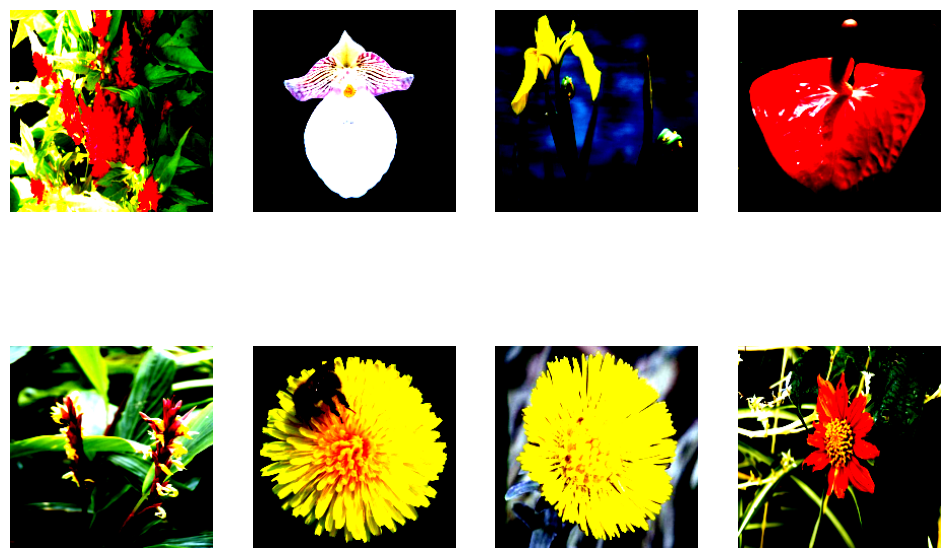

In [7]:
for x,y in train_loader:
    x = x.to(device)
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,8))
    for i in range(2):
        for j in range(4):
            ax[i,j].imshow(x[i*4+j].cpu().permute(1,2,0))
            ax[i,j].axis('off')
    break

In [8]:
def check_accuracy(loader, model):
    correct = 0
    samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            y_hat = model(x)
            _, predictions = y_hat.max(1)
            correct += (predictions == y).sum()
            samples += predictions.size(0)
    print(f"Accuracy: {correct}/{samples}: %{correct/samples*100:.2f}")
    model.train()

for epoch in range(NUM_EPOCHS):
    running_loss = 0
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)

        y_hat = model(x)
        loss = criterion(y_hat, y)
        running_loss += loss

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    print(f"Epoch {epoch+1} of {NUM_EPOCHS}, Loss: {running_loss}")
    check_accuracy(test_loader, model)
  

Epoch 1 of 6, Loss: 1355.0025634765625
Accuracy: 334/1689: %19.78
Epoch 2 of 6, Loss: 577.62060546875
Accuracy: 506/1689: %29.96
Epoch 3 of 6, Loss: 360.4828796386719
Accuracy: 558/1689: %33.04
Epoch 4 of 6, Loss: 207.8138885498047
Accuracy: 608/1689: %36.00
Epoch 5 of 6, Loss: 109.81519317626953
Accuracy: 639/1689: %37.83
Epoch 6 of 6, Loss: 58.479736328125
Accuracy: 660/1689: %39.08
